In [ ]:
#Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import top_k_categorical_accuracy

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer, word_tokenize 
from nltk.corpus import stopwords

import re
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
maxlen      = 100   # 设置序列长度为100，要保证序列长度不超过512
Batch_size  = 16    #批量运行的个数
Epoch       = 5

# Data

In [ ]:
#import data
train=pd.read_csv("drive/MyDrive/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("drive/MyDrive/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding='latin1')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)
test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)

In [ ]:
#look at NaN
nan = pd.DataFrame(train.isna().sum(), columns = ['NaN_sum'])
num_of_rows=41157
nan['Perc(%)'] = (nan['NaN_sum']/num_of_rows)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan

,NaN_sum,Perc(%)
Location,8590,20.871298


In [ ]:
#distribution of labels
train.Sentiment.value_counts(normalize= True)

Positive              0.277523
Negative              0.240955
Neutral               0.187404
Extremely Positive    0.160945
Extremely Negative    0.133173
Name: Sentiment, dtype: float64

In [ ]:
#data preprocessing
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def data_cleaner(tweet):
    # remove html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    # remove urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    # remove hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    # remove mentions
    tweet = re.sub(r'@\w+',' ', tweet) 
    # remove digits
    tweet = re.sub(r'\d+',' ', tweet)
    #removing stop words
    tweet = tweet.split()
    stop_words = stopwords.words('english')
    tweet = " ".join([word for word in tweet if not word in stop_words])  
    return tweet

X.head()

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: OriginalTweet, dtype: object

In [ ]:
#feature encoding
encoding = {'Extremely Negative': 0,
            'Negative': 1,
            'Neutral': 2,
            'Positive':3,
            'Extremely Positive': 4
           }

y.replace(encoding, inplace=True)

# Models

In [ ]:
!pip install keras_bert

  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp37-none-any.whl size=34144 sha256=600d4b1d3f9dc3f01c6b708c81cb6666ea01b3d998e13e01f950d1ef07231ca7
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for keras-transformer: filename=keras_transformer-0.38.0-cp37-none-any.whl size=12942 sha256=9a700da4ea128fcac9c69860ec22befc94bd1ed57bde0fdb77e7a4e4bf9062c0
  Stored in directory: /root/.cache/pip/wheels/e5/fb/3a/37b2b9326c799aa010ae46a04ddb04f320d8c77c0b7e837f4e
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp37-none-any.whl size=7554 sha256=8be9dfcf2ecc8b717c32b4952e3c0f42ad89bca07f9d7b4c12b8679bc95b2fc6
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp37-none-any.whl size=15611 sha256=2b2276942600234f04665bbb41231a43eccaf70e379901d6877196b19ba36ef7
  Stor

In [ ]:
from keras_bert import load_trained_model_from_checkpoint, Tokenizer
import codecs, gc

config_path = 'drive/MyDrive/multilingual_L-12_H-768_A-12/bert_config.json'
checkpoint_path = 'drive/MyDrive/multilingual_L-12_H-768_A-12/bert_model.ckpt'
dict_path = 'drive/MyDrive/multilingual_L-12_H-768_A-12/vocab.txt'



In [ ]:
def get_train_test_data():
    train_df=pd.read_csv("drive/MyDrive/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv",encoding='latin1')
    test_df=pd.read_csv("drive/MyDrive/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv",encoding='latin1')
    
    encoding = {'Extremely Negative': 0,
            'Negative': 1,
            'Neutral': 2,
            'Positive':3,
            'Extremely Positive': 4
           }
    
    # transform train/validation set
    DATA_LIST = []
    for data_row in train_df.iloc[:].itertuples():
        DATA_LIST.append((data_row.OriginalTweet, to_categorical(encoding[data_row.Sentiment], 5)))
    DATA_LIST = np.array(DATA_LIST,dtype=object)
    
 
    DATA_LIST_TEST = []
    for data_row in test_df.iloc[:].itertuples():
        DATA_LIST_TEST.append((data_row.OriginalTweet, to_categorical(encoding[data_row.Sentiment], 5)))
    DATA_LIST_TEST = np.array(DATA_LIST_TEST,dtype=object)
 
    data = DATA_LIST
    data_test = DATA_LIST_TEST
 
    X_train,X_valid = train_test_split(data,test_size=0.2,random_state = 0)
    
    return X_train,X_valid,data_test

X_train, X_valid, data_test = get_train_test_data()



In [ ]:
def get_token_dict():
    """
    # build reverse dict
    """
    token_dict = {}
    with codecs.open(dict_path, 'r', 'utf8') as reader:
        for line in reader:
            token = line.strip()
            token_dict[token] = len(token_dict)
    return token_dict
 
# 重写tokenizer
class OurTokenizer(Tokenizer):
    def _tokenize(self, text):
        R = []
        for c in text:
            if c in self._token_dict:
                R.append(c)
            elif self._is_space(c):
                R.append('[unused1]')  # 用[unused1]来表示空格类字符
            else:
                R.append('[UNK]')  # 不在列表的字符用[UNK]表示   UNK是unknown的意思
        return R
 
# 获取新的tokenizer
tokenizer = OurTokenizer(get_token_dict())


In [ ]:
def seq_padding(X, padding=0):
    """
    :param X: text list
    :param padding: padding element = 0
    """
    L = [len(x) for x in X]
    ML = max(L)
    return np.array([ np.concatenate([x, [padding] * (ML - len(x))]) if len(x) < ML else x for x in X])
 
 
class data_generator:
    def __init__(self, data, batch_size=Batch_size, shuffle=True):
        """
        :param data: text list
        :param batch_size:  
        :param shuffle: 
        """
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.steps = len(self.data) // self.batch_size
        if len(self.data) % self.batch_size != 0:
            self.steps += 1
 
    def __len__(self):
        return self.steps
 
    def __iter__(self):
        while True:
            idxs = list(range(len(self.data)))
 
            if self.shuffle:
                np.random.shuffle(idxs)
 
            X1, X2, Y = [], [], []
            for i in idxs:
                d = self.data[i]
                text = d[0][:maxlen]
                x1, x2 = tokenizer.encode(first=text)
                y = d[1]
                X1.append(x1)
                X2.append(x2)
                Y.append([y])
                if len(X1) == self.batch_size or i == idxs[-1]:
                    X1 = seq_padding(X1)
                    X2 = seq_padding(X2)
                    Y = seq_padding(Y)
                    yield [X1, X2], Y[:, 0, :]
                    [X1, X2, Y] = [], [], []
 
 
 
def acc_top2(y_true, y_pred):
    """
    :param y_true: real value
    :param y_pred: predict value
    :return: #top -k arccuracy
    """
    return top_k_categorical_accuracy(y_true, y_pred, k=2)


In [ ]:
def build_bert(nclass):
    """
    :param nclass: number of classes
    :return: bert model
    """
    bert_model = load_trained_model_from_checkpoint(config_path, checkpoint_path, seq_len=None)  # 加载预训练模型
 
    for l in bert_model.layers:
        l.trainable = True
    #构建模型
    x1_in = L.Input(shape=(None,))
    x2_in = L.Input(shape=(None,))
 
    x = bert_model([x1_in, x2_in])
    #x = L.Lambda(lambda x: x[:, 0])(x)  # 取出[CLS]对应的向量用来做分类
    x = x[:, 0]
    x = L.Dense(64, activation="relu")(x)
    x = L.Dropout(0.4)(x)
    p = L.Dense(nclass, activation='softmax')(x)
 
    model = Model([x1_in, x2_in], p)
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(1e-5),  # 用足够小的学习率
                  metrics=['accuracy'])
    print(model.summary())
    return model
 
 
def run_kb():
    """
    loading modal
    """
    print('loading model pleas wait....')
    model = build_bert(5)  
    print('Training start....')
    early_stopping = EarlyStopping(monitor='val_acc', patience=3)  # 
    plateau = ReduceLROnPlateau(monitor="val_acc", verbose=1, mode='max', factor=0.5, patience=2)  # when loss is not going down, lower learning rate
    checkpoint = ModelCheckpoint(r'drive/MyDrive/bert_dump1.hdf5', monitor='val_acc', verbose=2,
                                 save_best_only=True, mode='max', save_weights_only=True)  # save best
  
    X_train, X_valid, data_test = get_train_test_data()
    train_D = data_generator(X_train, shuffle=True)
    valid_D = data_generator(X_valid, shuffle=True)
    test_D = data_generator(data_test, shuffle=False)
 
    # 模型训练
    model.fit(
        train_D.__iter__(),
        steps_per_epoch=len(train_D),
        epochs=Epoch,
        validation_data=valid_D.__iter__(),
        validation_steps=len(valid_D),
        callbacks=[early_stopping, plateau, checkpoint],
        )
    # 对验证集和测试集进行预测
    valid_D = data_generator(X_valid, shuffle=False)
    train_model_pred = model.predict(valid_D.__iter__(), steps=len(valid_D), verbose=1)
    test_model_pred  = model.predict(test_D.__iter__(), steps=len(test_D), verbose=1)
    # 将预测概率值转化为类别值
    train_pred = [np.argmax(x) for x in train_model_pred]
    test_pred = [np.argmax(x) for x in test_model_pred]
    y_true = [np.argmax(x) for x in X_valid[:, 1]]
 
    return train_pred,test_pred,y_true,model,data_test
    
 
 
def bk_metrics(y_true,y_pred,type ='metrics'):
    
    print(type,'...')
    print(metrics.confusion_matrix(y_true,y_pred))
    print('准确率：',metrics.accuracy_score(y_true,y_pred))
    print('类别精度：',metrics.precision_score(y_true,y_pred,average = None)) #不求平均
    print('宏平均精度：',metrics.precision_score(y_true,y_pred,average = 'macro'))
    print('微平均召回率:',metrics.recall_score(y_true,y_pred,average = 'micro'))
    print('加权平均F1得分:',metrics.f1_score(y_true,y_pred,average = 'weighted'))
 
#
 


In [ ]:
X_train, X_valid, data_test = get_train_test_data()



In [ ]:
train_pred, test_pred, y_true,model,data_test = run_kb()

bk_metrics(train_pred,y_true,type =' train metrics')

bk_metrics(test_pred,[np.argmax(x) for x in data_test[:, 1]],type =' test metrics')
    # 将模型保存
model_path ='drive/MyDrive/bertkeras_model.h5'
model.save(model_path)

loading model pleas wait....
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, None, 768)    166765824   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0         

In [ ]:
from keras_bert import get_custom_objects
model = tf.keras.models.load_model('drive/MyDrive/bertkeras_model.h5', custom_objects=get_custom_objects())


In [ ]:
train_model_pred = model.predict(data_generator(X_train).__iter__())
print(train_model_pred)

In [ ]:
print(y_true)

[2, 1, 3, 4, 4, 0, 2, 2, 1, 2, 3, 1, 3, 3, 1, 4, 1, 3, 1, 1, 2, 3, 0, 3, 2, 2, 1, 2, 1, 3, 0, 2, 4, 3, 4, 1, 3, 4, 3, 1, 3, 3, 4, 4, 2, 4, 4, 1, 1, 0, 3, 4, 4, 1, 3, 1, 4, 2, 4, 0, 2, 1, 0, 3, 0, 3, 2, 0, 2, 2, 4, 2, 3, 0, 2, 2, 1, 1, 4, 4, 2, 3, 3, 0, 0, 4, 2, 1, 1, 1, 0, 1, 3, 2, 3, 3, 3, 1, 4, 4, 2, 4, 4, 0, 4, 1, 0, 4, 4, 1, 3, 1, 0, 2, 3, 4, 4, 1, 0, 3, 1, 4, 3, 3, 0, 4, 3, 3, 1, 0, 4, 3, 1, 3, 4, 0, 3, 3, 3, 2, 1, 1, 1, 4, 0, 2, 4, 3, 1, 0, 4, 1, 2, 2, 2, 1, 3, 1, 1, 2, 3, 1, 0, 3, 1, 1, 3, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 0, 2, 0, 3, 4, 2, 2, 3, 4, 2, 2, 3, 1, 2, 0, 3, 0, 1, 1, 3, 1, 2, 3, 3, 2, 3, 1, 2, 1, 3, 4, 1, 0, 4, 2, 2, 2, 0, 0, 1, 2, 3, 3, 4, 3, 4, 2, 1, 1, 1, 1, 3, 3, 1, 0, 2, 2, 4, 3, 4, 0, 3, 4, 3, 3, 3, 1, 1, 0, 1, 3, 3, 1, 3, 4, 3, 1, 2, 2, 3, 1, 3, 0, 1, 0, 1, 3, 2, 4, 4, 3, 3, 4, 3, 2, 1, 1, 2, 4, 2, 0, 0, 4, 0, 1, 0, 3, 3, 2, 2, 3, 1, 4, 2, 2, 1, 4, 0, 2, 1, 2, 4, 1, 1, 2, 4, 2, 1, 3, 2, 4, 3, 3, 0, 3, 2, 4, 2, 3, 2, 3, 1, 3, 1, 3, 3, 1, 1, 3, 4, 1, 1, 4, 0, 3, 

# Evaluation

In [ ]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()
X_test = X_test.apply(data_cleaner)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post')
y_test.replace(encoding, inplace=True)

In [ ]:
prediction = model.predict_classes(X_test)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


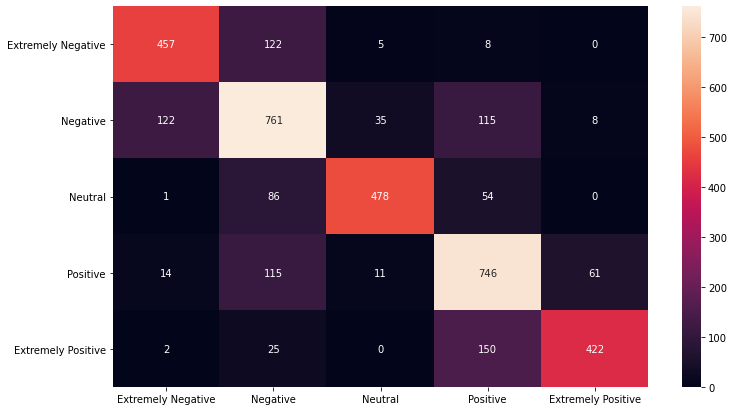

In [ ]:
conf = confusion_matrix(y_test, prediction)
labels = ['Extremely Negative','Negative', 'Neutral', 'Positive','Extremely Positive']
conf = pd.DataFrame( conf, index = [i for i in labels],columns = [i for i in labels])
plt.figure(figsize = (12,7))
sns.heatmap(conf, annot=True, fmt="d")
plt.show()

In [ ]:
print(classification_report(y_test, prediction, target_names=labels))

                    precision    recall  f1-score   support

Extremely Negative       0.77      0.77      0.77       592
          Negative       0.69      0.73      0.71      1041
           Neutral       0.90      0.77      0.83       619
          Positive       0.70      0.79      0.74       947
Extremely Positive       0.86      0.70      0.77       599

          accuracy                           0.75      3798
         macro avg       0.78      0.75      0.76      3798
      weighted avg       0.76      0.75      0.76      3798

